In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymatgen.core.composition import Composition
import scipy.stats
from scipy.stats import pearsonr
import collections
sns.set_context('paper', font_scale=2)

d:\ProgramData\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M, base=2)+0.5*scipy.stats.entropy(q, M, base=2)

def KL_divergence(p,q):
    return scipy.stats.entropy(p, q, base=2)

def eculidDisSim(x,y):
    '''
    欧几里得相似度
    '''
    return np.sqrt(sum(pow(a-b,2) for a,b in zip(x,y)))

def manhattanDisSim(x,y):
    '''
    曼哈顿相似度
    '''
    return sum(abs(a-b) for a,b in zip(x,y))

def cosSim(x,y):
    '''
    余弦相似度
    '''
    tmp=np.sum(x*y)
    non=np.linalg.norm(x)*np.linalg.norm(y)
    return np.round(tmp/float(non),9)

def pearsonrSim(x,y):
    '''
    皮尔森相似度
    '''
    return pearsonr(x,y)[0]

## 2

In [148]:
str_f = 'As'
s_name = '2'
# %%
# data_dir = f'data/embeddings_L-ATT-RES-DCNN-512/ENV/{str_f}/3'
data_dir = f'data/embeddings_L-ATT-RES-DCNN-512/ENV_OQMD_band_train_val/{str_f}/{s_name}'
if isinstance(data_dir, list):
    mat_props = data_dir
elif os.path.isdir(data_dir):
    mat_props = os.listdir(data_dir)
else:
    mat_props = [data_dir]

# %%
name1 = [i.split('.csv')[0] for i in mat_props if i.split('.csv')[0] == 'fraction_fomula']
path_formula = os.path.join(data_dir, f'{name1[0]}.csv')
df_f = pd.read_csv(path_formula)
formu_2 = df_f['formula'].values

row_ind = 2
save_num_2 = np.zeros((len(mat_props)-1, row_ind, row_ind))

for i, mat_prop in enumerate(mat_props):
    if mat_prop.split('.csv')[0] == 'fraction_fomula':
        mat_props.pop(i)
for i, mat_prop in enumerate(mat_props):   
    if os.path.isfile(mat_prop):
        name = os.path.basename(mat_prop).split('.csv')[0]
        path = mat_prop
    elif os.path.isdir(data_dir):
        name = mat_prop.split('.csv')[0]
        path = os.path.join(data_dir, f'{name}.csv')
    else:
        path = data_dir
        name = mat_prop.split('/')[-1].split('.csv')[0]
        
    # read csv files
    df = pd.read_csv(path)
    if 'element' not in df.columns:
        df['element'] = df.iloc[:,0]
        df = df.drop(columns=['Unnamed: 0'])

    # get rid of 'Null' element representation
    null_row = df['element'] == 'Null'
    df = df[~null_row]

    # grab only the elements that are in oliynyk
    df.index = df['element']
    
    # df.index = df['model']
    # df = df.loc[oliynyk_elements]

    elements = df.pop('element')
    
    # %%
    # normalize the dataframe
    # zero mean, unit variance
    # df = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)
  
    current_elements = elements
    df_extended = df.reindex(current_elements)
    dfT = df_extended.T
    dfT.columns = current_elements
    corr2 = dfT.corr()

    save_num_2[i,:,:] = corr2.values
    # mask = np.triu(np.ones_like(corr2, dtype=bool))



thred_v = 0.01
# thred_v = 0.1
all_dict2 = dict(zip(formu_2, save_num_2)) 
index_coll2 = dict()

k = 0
for k1,values in all_dict2.items():
    ll_k = []
    ll_v = []
    vv_k = []
    vv_v = []
    for k2,value_q in all_dict2.items():
        if np.abs(np.subtract(values, value_q)).max() <= thred_v:
            ll_v.append(value_q)
            ll_k.append(k2)
        else:
            vv_v.append(value_q)
            vv_k.append(k2)
    if len(ll_v) != 0:
        index_coll2[str(k)] = dict(zip(ll_k, ll_v))
        k = k+1
    if len(vv_v) != 0 and len(vv_v) != 1: 
        all_dict2 = dict()
        all_dict2 = dict(zip(vv_k, vv_v))
    else:
        break
        
if len(vv_v) != 0:       
    index_coll2[str(k)] = dict(zip(vv_k, vv_v))

# puzzle large matrix
puzzle_dict = {}
for i,v in index_coll2.items():
    for k, dic_v in v.items():
        puzzle_dict[i] = dict(zip([k],[dic_v]))
        continue

# 得到每个环境下的一个pearson矩阵放到puzzle_arr
puzzle_arr = np.zeros((len(index_coll2), row_ind, row_ind))
for i,v in puzzle_dict.items():
    for _, subsets in v.items():
            puzzle_arr[int(i),:,:] = subsets

# puzzle_arr.shape[0],3,3 转成 puzzle_arr.shape[0],3,2
puzzle_arr_downscale = np.zeros((len(index_coll2), row_ind, row_ind-1))
for i in range(puzzle_arr.shape[0]):
    A = puzzle_arr[i]
    puzzle_arr_downscale[i,:,:] = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

# 降维 reshape 方便绘制heatmap
puzzle_arr_trans = puzzle_arr_downscale.reshape(len(index_coll2),-1) 

# 删除array中的相同值
puzzle_arr_trans_diff2 = np.unique(puzzle_arr_trans, axis=1)
corr_2 = np.linalg.norm(puzzle_arr_trans_diff2, ord=np.Inf, axis=1, keepdims=True) # 范数inf

In [149]:
sorted(corr_2)

[array([0.63856586]),
 array([0.67559784]),
 array([0.70736113]),
 array([0.74886336]),
 array([0.8327496]),
 array([0.84957768]),
 array([0.86919645]),
 array([0.88582961]),
 array([0.90945419]),
 array([0.92500802]),
 array([0.93706058]),
 array([0.95225359]),
 array([0.96438995]),
 array([0.97630477]),
 array([0.98012227]),
 array([0.98032474]),
 array([0.99168302])]

In [147]:
sorted(corr_2)

[array([0.67559784]),
 array([0.70736113]),
 array([0.74886336]),
 array([0.8327496]),
 array([0.84957768]),
 array([0.90945419]),
 array([0.92500802]),
 array([0.93706058]),
 array([0.96438995])]

In [145]:
sorted(corr_2)

[array([0.70736113]),
 array([0.74886336]),
 array([0.8327496]),
 array([0.86919645]),
 array([0.88582961]),
 array([0.96438995])]

## 3

In [3]:
str_f = 'Si'
# s_d = 'ENV_OQMD_band_test'
# s_d = 'ENV_aflow_band_test'
s_d = 'ENV_OQMD_Formation_Enthalpy_test'
# s_d = 'ENV_OQMD_Energy_per_atom_test'
# s_d = 'ENV_aflow__energy_atom_test'
# s_d = 'ENV_matbench_mp_gap_test'
# s_d = 'ENV_matbench_log_gvrh0_test'
# s_d = 'ENV_OQMD_Volume_per_atom_test'
# s_d = 'ENV_CritExam_Ed_test'

# dir_s = 'embeddings_GRU'  
# dir_s = 'embeddings_L-ATT-RES-DCNN-512'
# dir_s = 'embeddings_L-ATT-RES-1-DCNN-512'
# dir_s = 'embeddings_LDCNN-256'
# dir_s = 'embeddings_LSTM_frac2000'
# dir_s = 'embeddings_RNN'
# dir_s = 'embeddings_multi_dpcnn_v8_2'
# dir_s = 'embeddings_multi_dpcnn_v8_k3_512_frac2000'

# dir_s = 'embeddings_LDCNN-512-10-3'
# dir_s = 'embeddings_LDCNN-512-RES'
# dir_s = 'embeddings_L-G-DCNN-4B' 
# dir_s = 'embeddings_L-ATT-RES-DCNN-512'
# dir_s = 'embeddings_L-ATT-DCNN-512'
# dir_s = 'embeddings_L-ATT-RES-1-3-Blocks-DCNN-512'
# dir_s = 'embeddings_L-ATT-L-ATT-DCNN-512'

# dir_s = 'CritExam__Ef/embeddings_L-ATT-RES-r-conv-r-DCNN-7B'
# dir_s = 'CritExam__Ef/embeddings_L-G-ATT-RES-1-DCNN-8B'
# dir_s = 'CritExam__Ef/embeddings_L-G-ATT-RES-1-r-RES-DCNN-2B'
# dir_s = 'CritExam__Ef/embeddings_L-G-bing-ATT-RES-1-r-RES-DCNN-2B'
# dir_s = 'CritExam__Ef/embeddings_L-G-R-ATT-RES-1-DCNN-2B'

# dir_s = 'Fraction2000/embeddings_L-DCNN-2B'
# dir_s = 'Fraction2000/L-selfattention1d-GDCNN-Fusion-pool4B'
# dir_s = 'Fraction2000/embeddings_L-G-DCNN-2B-fusion-pool'
dir_s = 'Fraction2000/embeddings_L-G-DCNN-2B'   
# dir_s = 'Fraction2000/embeddings_L-G-DCNN-4B'
# dir_s = 'Fraction2000/L-selfattention1d-GDCNN'
# dir_s = 'Fraction2000/embeddings_LGDCNN-maxpool-add-3'

num = 5
s_n = 'DCNN_sequential_' + str(num) + '_layers'
# s_n = 'TransformerEncoder' + str(num) + '_layers'
# s_n = 'Dropout' + str(num) + '_layers'
# s_n = 'LSTM_output' + str(num)
# s_n = 'GRU_output' + str(num)
# s_n = 'RNN_output' + str(num)
# s_n = 'embeddings_RDCNN' + str(num)


for thred_v in [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]:
    # data_dir = f'data/embeddings_L-ATT-RES-DCNN-512/ENV/{str_f}/3'
    # data_dir = f'data/embeddings_L-ATT-RES-DCNN-512/ENV_OQMD_band_train_val/{str_f}/{s_name}'
    s_name = '3'
    data_dir = f'data/{dir_s}/{s_d}/{str_f}/{s_n}/{s_name}'
    if isinstance(data_dir, list):
        mat_props = data_dir
    elif os.path.isdir(data_dir):
        mat_props = os.listdir(data_dir)
    else:
        mat_props = [data_dir]

    # %%
    name1 = [i.split('.csv')[0] for i in mat_props if i.split('.csv')[0] == 'fraction_fomula']
    path_formula = os.path.join(data_dir, f'{name1[0]}.csv')
    df_f = pd.read_csv(path_formula)
    formu = df_f['formula'].values

    row_ind = 3
    save_num = np.zeros((len(mat_props)-1,row_ind,row_ind))

    for i, mat_prop in enumerate(mat_props):
        if mat_prop.split('.csv')[0] == 'fraction_fomula':
            mat_props.pop(i)
    for i, mat_prop in enumerate(mat_props):   
        if os.path.isfile(mat_prop):
            name = os.path.basename(mat_prop).split('.csv')[0]
            path = mat_prop
        elif os.path.isdir(data_dir):
            name = mat_prop.split('.csv')[0]
            path = os.path.join(data_dir, f'{name}.csv')
        else:
            path = data_dir
            name = mat_prop.split('/')[-1].split('.csv')[0]
            
        # read csv files
        df = pd.read_csv(path)
        if 'element' not in df.columns:
            df['element'] = df.iloc[:,0]
            df = df.drop(columns=['Unnamed: 0'])

        # get rid of 'Null' element representation
        null_row = df['element'] == 'Null'
        df = df[~null_row]

        # grab only the elements that are in oliynyk
        df.index = df['element']
        
        # df.index = df['model']
        # df = df.loc[oliynyk_elements]

        elements = df.pop('element')
        
        # %%
        # normalize the dataframe
        # zero mean, unit variance
        df = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)
    
        current_elements = elements
        df_extended = df.reindex(current_elements)
        dfT = df_extended.T
        dfT.columns = current_elements
        corr2 = dfT.corr()

        save_num[i,:,:] = corr2.values
        # mask = np.triu(np.ones_like(corr2, dtype=bool))


    all_dict = dict(zip(formu, save_num)) 
    index_coll = collections.OrderedDict()

    k = 0
    for k1,values in all_dict.items():
        ll_k = []
        ll_v = []
        vv_k = []
        vv_v = []
        for k2,value_q in all_dict.items():
            if np.abs((np.subtract(np.abs(values), np.abs(value_q)))).max() < thred_v:
                ll_v.append(value_q)
                ll_k.append(k2)
            else:
                vv_v.append(value_q)
                vv_k.append(k2)
        if len(ll_v) != 0:
            index_coll[str(k)] = dict(zip(ll_k, ll_v))
            k = k+1
        if len(vv_v) != 0 and len(vv_v) != 1: 
            all_dict = dict()
            all_dict = dict(zip(vv_k, vv_v))
        else:
            break

    if len(vv_v) != 0:       
        index_coll[str(k)] = dict(zip(vv_k, vv_v))

    # puzzle large matrix
    # puzzle_dict = {}
    puzzle_dict = collections.OrderedDict()
    for i,v in index_coll.items():
            first_key = next(iter(v))
            puzzle_dict[i] = dict(zip([first_key],[v[first_key]]))
            continue

    # 得到每个环境下的一个pearson矩阵放到puzzle_arr
    puzzle_arr = np.zeros((len(index_coll), row_ind, row_ind))
    for i,v in puzzle_dict.items():
        for _, subsets in v.items():
                puzzle_arr[int(i),:,:] = subsets

    # puzzle_arr.shape[0],3,3 转成 puzzle_arr.shape[0],3,2
    puzzle_arr_downscale = np.zeros((len(index_coll), row_ind, row_ind-1))
    for i in range(puzzle_arr.shape[0]):
        A = puzzle_arr[i]
        puzzle_arr_downscale[i,:,:] = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

    # 降维 reshape 方便绘制heatmap
    puzzle_arr_trans = puzzle_arr_downscale.reshape(len(index_coll),-1) # [168,9]

    # 删除array中的相同值
    puzzle_arr_trans_diff = np.unique(puzzle_arr_trans, axis=1)
    corr = np.linalg.norm(puzzle_arr_trans_diff, ord=np.Inf, axis=1, keepdims=True) # 范数inf


############################################################################################
    s_name = '4'
    data_dir = f'data/{dir_s}/{s_d}/{str_f}/{s_n}/{s_name}'
    if isinstance(data_dir, list):
        mat_props = data_dir
    elif os.path.isdir(data_dir):
        mat_props = os.listdir(data_dir)
    else:
        mat_props = [data_dir]

    # %%
    name1 = [i.split('.csv')[0] for i in mat_props if i.split('.csv')[0] == 'fraction_fomula']
    path_formula = os.path.join(data_dir, f'{name1[0]}.csv')
    df_f = pd.read_csv(path_formula)
    formu_4 = df_f['formula'].values

    row_ind_4 = 4
    save_num_4 = np.zeros((len(mat_props)-1, row_ind_4, row_ind_4))

    for i, mat_prop in enumerate(mat_props):
        if mat_prop.split('.csv')[0] == 'fraction_fomula':
            mat_props.pop(i)
    for i, mat_prop in enumerate(mat_props):   
        if os.path.isfile(mat_prop):
            name = os.path.basename(mat_prop).split('.csv')[0]
            path = mat_prop
        elif os.path.isdir(data_dir):
            name = mat_prop.split('.csv')[0]
            path = os.path.join(data_dir, f'{name}.csv')
        else:
            path = data_dir
            name = mat_prop.split('/')[-1].split('.csv')[0]
            
        # read csv files
        df = pd.read_csv(path)
        if 'element' not in df.columns:
            df['element'] = df.iloc[:,0]
            df = df.drop(columns=['Unnamed: 0'])

        # get rid of 'Null' element representation
        null_row = df['element'] == 'Null'
        df = df[~null_row]

        # grab only the elements that are in oliynyk
        df.index = df['element']
        
        # df.index = df['model']
        # df = df.loc[oliynyk_elements]

        elements = df.pop('element')
        
        # %%
        # normalize the dataframe
        # zero mean, unit variance
        df = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)
    
        current_elements = elements
        df_extended = df.reindex(current_elements)
        dfT = df_extended.T
        dfT.columns = current_elements
        corr2 = dfT.corr()

        save_num_4[i,:,:] = corr2.values
        # mask = np.triu(np.ones_like(corr2, dtype=bool))

    all_dict_4 = dict(zip(formu_4, save_num_4)) 
    index_coll_4 = collections.OrderedDict()

    k = 0
    for k1,values in all_dict_4.items():
        ll_k = []
        ll_v = []
        vv_k = []
        vv_v = []
        for k2,value_q in all_dict_4.items():
            if np.abs(np.subtract(values, value_q)).max() <= thred_v:
                ll_v.append(value_q)
                ll_k.append(k2)
            else:
                vv_v.append(value_q)
                vv_k.append(k2)
        if len(ll_v) != 0:
            index_coll_4[str(k)] = dict(zip(ll_k, ll_v))
            k = k+1
        if len(vv_v) != 0 and len(vv_v) != 1: 
            all_dict_4 = dict()
            all_dict_4 = dict(zip(vv_k, vv_v))
        else:
            break
            
    if len(vv_v) != 0:       
        index_coll_4[str(k)] = dict(zip(vv_k, vv_v))

    # puzzle large matrix
    puzzle_dict = collections.OrderedDict()
    for i,v in index_coll_4.items():
            first_key = next(iter(v))
            puzzle_dict[i] = dict(zip([first_key],[v[first_key]]))
            continue

    # 得到每个环境下的一个pearson矩阵放到puzzle_arr
    puzzle_arr = np.zeros((len(index_coll_4), row_ind_4, row_ind_4))
    for i,v in puzzle_dict.items():
        for _, subsets in v.items():
                puzzle_arr[int(i),:,:] = subsets

    # puzzle_arr.shape[0],3,3 转成 puzzle_arr.shape[0],3,2
    puzzle_arr_downscale = np.zeros((len(index_coll_4), row_ind_4, row_ind_4-1))
    for i in range(puzzle_arr.shape[0]):
        A = puzzle_arr[i]
        puzzle_arr_downscale[i,:,:] = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

    # 降维 reshape 方便绘制heatmap
    puzzle_arr_trans = puzzle_arr_downscale.reshape(len(index_coll_4),-1) # [168,9]

    # 删除array中的相同值
    puzzle_arr_trans_diff_4 = np.unique(puzzle_arr_trans, axis=1)

    corr_4 = np.linalg.norm(puzzle_arr_trans_diff_4, ord=np.Inf, axis=1, keepdims=True) # 范数inf



#####################################################################################################################
    s_name = '5'
    data_dir = f'data/{dir_s}/{s_d}/{str_f}/{s_n}/{s_name}'
    if isinstance(data_dir, list):
        mat_props = data_dir
    elif os.path.isdir(data_dir):
        mat_props = os.listdir(data_dir)
    else:
        mat_props = [data_dir]

    name1 = [i.split('.csv')[0] for i in mat_props if i.split('.csv')[0] == 'fraction_fomula']
    path_formula = os.path.join(data_dir, f'{name1[0]}.csv')
    df_f = pd.read_csv(path_formula)
    formu_5 = df_f['formula'].values

    row_ind_5 = 5
    save_num_5 = np.zeros((len(mat_props)-1, row_ind_5, row_ind_5))

    for i, mat_prop in enumerate(mat_props):
        if mat_prop.split('.csv')[0] == 'fraction_fomula':
            mat_props.pop(i)
    for i, mat_prop in enumerate(mat_props):   
        if os.path.isfile(mat_prop):
            name = os.path.basename(mat_prop).split('.csv')[0]
            path = mat_prop
        elif os.path.isdir(data_dir):
            name = mat_prop.split('.csv')[0]
            path = os.path.join(data_dir, f'{name}.csv')
        else:
            path = data_dir
            name = mat_prop.split('/')[-1].split('.csv')[0]
            
        # read csv files
        df = pd.read_csv(path)
        if 'element' not in df.columns:
            df['element'] = df.iloc[:,0]
            df = df.drop(columns=['Unnamed: 0'])

        # get rid of 'Null' element representation
        null_row = df['element'] == 'Null'
        df = df[~null_row]

        # grab only the elements that are in oliynyk
        df.index = df['element']
        
        # df.index = df['model']
        # df = df.loc[oliynyk_elements]

        elements = df.pop('element')
        
        # %%
        # normalize the dataframe
        # zero mean, unit variance
        df = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)
        current_elements = elements
        df_extended = df.reindex(current_elements)
        dfT = df_extended.T
        dfT.columns = current_elements
        corr2 = dfT.corr()

        save_num_5[i,:,:] = corr2.values
        # mask = np.triu(np.ones_like(corr2, dtype=bool))

    all_dict_5 = dict(zip(formu_5, save_num_5)) 
    index_coll_5 = collections.OrderedDict()

    k = 0
    for k1,values in all_dict_5.items():
        ll_k = []
        ll_v = []
        vv_k = []
        vv_v = []
        for k2,value_q in all_dict_5.items():
            if np.abs(np.subtract(values, value_q)).max() <= thred_v:
                ll_v.append(value_q)
                ll_k.append(k2)
            else:
                vv_v.append(value_q)
                vv_k.append(k2)
        if len(ll_v) != 0:
            index_coll_5[str(k)] = dict(zip(ll_k, ll_v))
            k = k+1
        if len(vv_v) != 0 and len(vv_v) != 1: 
            all_dict_5 = dict()
            all_dict_5 = dict(zip(vv_k, vv_v))
        else:
            break
            
    if len(vv_v) != 0:       
        index_coll_5[str(k)] = dict(zip(vv_k, vv_v))


    # puzzle large matrix
    puzzle_dict = collections.OrderedDict()
    for i,v in index_coll_5.items():
            first_key = next(iter(v))
            puzzle_dict[i] = dict(zip([first_key],[v[first_key]]))
            continue

    # 得到每个环境下的一个pearson矩阵放到puzzle_arr
    puzzle_arr = np.zeros((len(index_coll_5), row_ind_5, row_ind_5))
    for i,v in puzzle_dict.items():
        for _, subsets in v.items():
                puzzle_arr[int(i),:,:] = subsets

    # puzzle_arr.shape[0],3,3 转成 puzzle_arr.shape[0],3,2
    puzzle_arr_downscale = np.zeros((len(index_coll_5), row_ind_5, row_ind_5-1))
    for i in range(puzzle_arr.shape[0]):
        A = puzzle_arr[i]
        puzzle_arr_downscale[i,:,:] = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

    # 降维 reshape 方便绘制heatmap
    puzzle_arr_trans = puzzle_arr_downscale.reshape(len(index_coll_5),-1) 

    # 删除array中的相同值
    puzzle_arr_trans_diff_5 = np.unique(puzzle_arr_trans, axis=1)

    corr_5 = np.linalg.norm(puzzle_arr_trans_diff_5, ord=np.Inf, axis=1, keepdims=True) # 范数inf

#####################################################################################################################
    s_name = '6'
    data_dir = f'data/{dir_s}/{s_d}/{str_f}/{s_n}/{s_name}'
    if isinstance(data_dir, list):
        mat_props = data_dir
    elif os.path.isdir(data_dir):
        mat_props = os.listdir(data_dir)
    else:
        mat_props = [data_dir]

    # %%
    name1 = [i.split('.csv')[0] for i in mat_props if i.split('.csv')[0] == 'fraction_fomula']
    path_formula = os.path.join(data_dir, f'{name1[0]}.csv')
    df_f = pd.read_csv(path_formula)
    formu_6 = df_f['formula'].values

    row_ind_6 = 6
    save_num_6 = np.zeros((len(mat_props)-1, row_ind_6, row_ind_6))

    for i, mat_prop in enumerate(mat_props):
        if mat_prop.split('.csv')[0] == 'fraction_fomula':
            mat_props.pop(i)
    for i, mat_prop in enumerate(mat_props):   
        if os.path.isfile(mat_prop):
            name = os.path.basename(mat_prop).split('.csv')[0]
            path = mat_prop
        elif os.path.isdir(data_dir):
            name = mat_prop.split('.csv')[0]
            path = os.path.join(data_dir, f'{name}.csv')
        else:
            path = data_dir
            name = mat_prop.split('/')[-1].split('.csv')[0]
            
        # read csv files
        df = pd.read_csv(path)
        if 'element' not in df.columns:
            df['element'] = df.iloc[:,0]
            df = df.drop(columns=['Unnamed: 0'])

        # get rid of 'Null' element representation
        null_row = df['element'] == 'Null'
        df = df[~null_row]

        # grab only the elements that are in oliynyk
        df.index = df['element']
        
        # df.index = df['model']
        # df = df.loc[oliynyk_elements]

        elements = df.pop('element')
        
        # %%
        # normalize the dataframe
        # zero mean, unit variance
        df = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)
        current_elements = elements
        df_extended = df.reindex(current_elements)
        dfT = df_extended.T
        dfT.columns = current_elements
        corr2 = dfT.corr()

        save_num_6[i,:,:] = corr2.values
        # mask = np.triu(np.ones_like(corr2, dtype=bool))

    all_dict_6 = dict(zip(formu_6, save_num_6)) 
    index_coll_6 = collections.OrderedDict()

    k = 0
    for k1,values in all_dict_6.items():
        ll_k = []
        ll_v = []
        vv_k = []
        vv_v = []
        for k2,value_q in all_dict_6.items():
            if np.abs(np.subtract(values, value_q)).max() <= thred_v:
                ll_v.append(value_q)
                ll_k.append(k2)
            else:
                vv_v.append(value_q)
                vv_k.append(k2)
        if len(ll_v) != 0:
            index_coll_6[str(k)] = dict(zip(ll_k, ll_v))
            k = k+1
        if len(vv_v) != 0 and len(vv_v) != 1: 
            all_dict_6 = dict()
            all_dict_6 = dict(zip(vv_k, vv_v))
        else:
            break
            
    if len(vv_v) != 0:       
        index_coll_6[str(k)] = dict(zip(vv_k, vv_v))


    # puzzle large matrix
    puzzle_dict = collections.OrderedDict()
    for i,v in index_coll_6.items():
            first_key = next(iter(v))
            puzzle_dict[i] = dict(zip([first_key],[v[first_key]]))
            continue

    # 得到每个环境下的一个pearson矩阵放到puzzle_arr
    puzzle_arr = np.zeros((len(index_coll_6), row_ind_6, row_ind_6))
    for i,v in puzzle_dict.items():
        for _, subsets in v.items():
                puzzle_arr[int(i),:,:] = subsets

    # puzzle_arr.shape[0],3,3 转成 puzzle_arr.shape[0],3,2
    puzzle_arr_downscale = np.zeros((len(index_coll_6), row_ind_6, row_ind_6 - 1))
    for i in range(puzzle_arr.shape[0]):
        A = puzzle_arr[i]
        puzzle_arr_downscale[i,:,:] = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

    # 降维 reshape 方便绘制heatmap
    puzzle_arr_trans = puzzle_arr_downscale.reshape(len(index_coll_6),-1) 

    # 删除array中的相同值
    puzzle_arr_trans_diff_6 = np.unique(puzzle_arr_trans, axis=1)
    corr_6 = np.linalg.norm(puzzle_arr_trans_diff_6, ord=np.Inf, axis=1, keepdims=True) # 范数inf
#####################################################################################################################
    
    s_name = '7'
    data_dir = f'data/{dir_s}/{s_d}/{str_f}/{s_n}/{s_name}'
    if isinstance(data_dir, list):
        mat_props = data_dir
    elif os.path.isdir(data_dir):
        mat_props = os.listdir(data_dir)
    else:
        mat_props = [data_dir]

    # %%
    name1 = [i.split('.csv')[0] for i in mat_props if i.split('.csv')[0] == 'fraction_fomula']
    path_formula = os.path.join(data_dir, f'{name1[0]}.csv')
    df_f = pd.read_csv(path_formula)
    formu_7 = df_f['formula'].values

    row_ind_7 = 7
    save_num_7 = np.zeros((len(mat_props)-1, row_ind_7, row_ind_7))

    for i, mat_prop in enumerate(mat_props):
        if mat_prop.split('.csv')[0] == 'fraction_fomula':
            mat_props.pop(i)
    for i, mat_prop in enumerate(mat_props):   
        if os.path.isfile(mat_prop):
            name = os.path.basename(mat_prop).split('.csv')[0]
            path = mat_prop
        elif os.path.isdir(data_dir):
            name = mat_prop.split('.csv')[0]
            path = os.path.join(data_dir, f'{name}.csv')
        else:
            path = data_dir
            name = mat_prop.split('/')[-1].split('.csv')[0]
            
        # read csv files
        df = pd.read_csv(path)
        if 'element' not in df.columns:
            df['element'] = df.iloc[:,0]
            df = df.drop(columns=['Unnamed: 0'])

        # get rid of 'Null' element representation
        null_row = df['element'] == 'Null'
        df = df[~null_row]

        # grab only the elements that are in oliynyk
        df.index = df['element']
        
        elements = df.pop('element')

        df = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)
        current_elements = elements
        df_extended = df.reindex(current_elements)
        dfT = df_extended.T
        dfT.columns = current_elements
        corr2 = dfT.corr()

        save_num_7[i,:,:] = corr2.values

    all_dict_7 = dict(zip(formu_7, save_num_7)) 
    index_coll_7 = collections.OrderedDict()

    k = 0
    for k1,values in all_dict_7.items():
        ll_k = []
        ll_v = []
        vv_k = []
        vv_v = []
        for k2,value_q in all_dict_7.items():
            if np.abs(np.subtract(values, value_q)).max() <= thred_v:
                ll_v.append(value_q)
                ll_k.append(k2)
            else:
                vv_v.append(value_q)
                vv_k.append(k2)
        if len(ll_v) != 0:
            index_coll_7[str(k)] = dict(zip(ll_k, ll_v))
            k = k+1
        if len(vv_v) != 0 and len(vv_v) != 1: 
            all_dict_7 = dict()
            all_dict_7 = dict(zip(vv_k, vv_v))
        else:
            break
            
    if len(vv_v) != 0:       
        index_coll_7[str(k)] = dict(zip(vv_k, vv_v))

    # puzzle large matrix
    puzzle_dict = collections.OrderedDict()
    for i,v in index_coll_7.items():
            first_key = next(iter(v))
            puzzle_dict[i] = dict(zip([first_key],[v[first_key]]))
            continue

    # 得到每个环境下的一个pearson矩阵放到puzzle_arr
    puzzle_arr = np.zeros((len(index_coll_7), row_ind_7, row_ind_7))
    for i,v in puzzle_dict.items():
        for _, subsets in v.items():
                puzzle_arr[int(i),:,:] = subsets

    # puzzle_arr.shape[0],3,3 转成 puzzle_arr.shape[0],3,2
    puzzle_arr_downscale = np.zeros((len(index_coll_7), row_ind_7, row_ind_7 - 1))
    for i in range(puzzle_arr.shape[0]):
        A = puzzle_arr[i]
        puzzle_arr_downscale[i,:,:] = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

    # 降维 reshape 方便绘制heatmap
    puzzle_arr_trans = puzzle_arr_downscale.reshape(len(index_coll_7),-1) 

    # 删除array中的相同值
    puzzle_arr_trans_diff_7 = np.unique(puzzle_arr_trans, axis=1)

    corr_7 = np.linalg.norm(puzzle_arr_trans_diff_7, ord=np.Inf, axis=1, keepdims=True) # 范数inf


    
    
    corr_conc = np.concatenate((corr, corr_4, corr_5, corr_6, corr_7),axis=0) 
    # str_f_r = 'correlation_atoms_L-ATT-RES-1-DCNN-512-model_design'
    # str_f_r = 'correlation_atoms_L-ATT-RES-1-DCNN-512'
    # str_f_r = 'correlation_atoms_LSTM'
    # str_f_r = 'correlation_atoms_LDCNN-512'
    # str_f_r = 'correlation_atoms_L-ATT-RES-4-Blocks-DCNN-512'
    # str_f_r = 'correlation_atoms_LDCNN-512-RES'
    # str_f_r = 'correlation_atoms_L-ATT-4-Blocks-DCNN'  
    # str_f_r = 'correlation_atoms_L-ATT-RES-1-4-Blocks-DCNN-512' 
    # str_f_r = 'correlation_atoms_L-ATT-DCNN'  
    # str_f_r = 'correlation_atoms_L-ATT-RES-DCNN-512' 

    # fig_dir_overall = f'figures/{str_f_r}/{s_d}/{str_f}/{thred_v}/'
    # os.makedirs(fig_dir_overall, exist_ok=True)
    # # # plot static figure
    # cmap = sns.diverging_palette(260, 15, s=80, l=50, n=10, center='light')
    # cbar_kws = dict(shrink=0.8)
    # fig = plt.figure(figsize=(3,30))
    # ax = sns.heatmap(
    #                 sorted(corr_conc),
    #                 # xticklabels=z_ticks,
    #                 # yticklabels=z_ticks,
    #                 # vmin=0.5, vmax=1,
    #                 # vmin=0.85, vmax=1.25, center=1.05,
    #                 # vmin=0.8, vmax=1.3, center=1.05,
    #                 annot=True,
    #                 annot_kws={"fontsize":5},
    #                 fmt=".3f",
    #                 cmap=cmap,
    #                 # cmap='rainbow',
    #                 linewidth=.5,
    #                 cbar_kws=cbar_kws
    #             )

    # ax.set_xticks([])
    # ax.set_yticklabels(
    #                 ax.get_yticklabels(),
    #                 rotation=45,
    #                 horizontalalignment='center',fontsize='small'
    #             )

    # plt.xlabel("Environmental feature embedding vectors")
    # plt.ylabel("Chemical environment")
    # plt.title(f'{str_f}')
    # for tick in ax.xaxis.get_major_ticks():
    #                 tick.set_pad(1)
    # for tick in ax.yaxis.get_major_ticks():
    #                 tick.set_pad(15)

    # # fig_path = os.path.join(fig_dir_overall, f'OQMD_Bandgap_Sequential_out_layer_{num}_ENV__{str_f}_corr_atoms.jpg')
    # fig_path = os.path.join(fig_dir_overall, f'OQMD_Bandgap_LSTM_out_layer_{num}_ENV_{str_f}_corr_atoms.jpg')
    # plt.savefig(fig_path, bbox_inches='tight', dpi=400)
    # plt.close('all')

    print(f'{num}-----{thred_v}:  {corr_conc.shape[0]}')


5-----0.05:  678
5-----0.1:  300
5-----0.15:  154
5-----0.2:  86
5-----0.25:  58


## fusion strategy SI

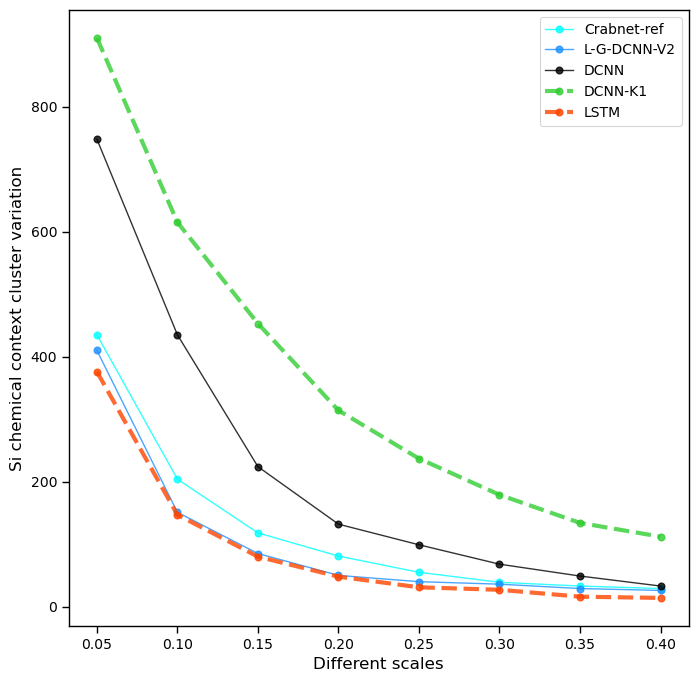

In [27]:
dict_L_ATT_RES = collections.OrderedDict()

exp0_key_region = ['Crabnet-ref','L-G-DCNN-V2','DCNN','DCNN-K1','LSTM']
Crabnet = [435, 204, 118, 81, 55, 39, 33, 29]
L_G_DCNN_V2= [410, 151, 85, 50, 40, 36, 29, 26]
# L_G_DCNN_V2 = [327, 117, 70, 42, 32, 22, 19, 15]
DCNN =  [748, 435, 224, 132, 99, 68, 49, 33]
DCNN_K1 = [910, 615, 453, 314, 237, 179, 134, 112]
LSTM = [376, 147, 80, 48, 31, 27, 16, 14]
exp0_key_v = [Crabnet, L_G_DCNN_V2, DCNN, DCNN_K1, LSTM]
dict_L_ATT_RES['last0'] = dict(zip(exp0_key_region[:-2], exp0_key_v[:-2]))
dict_L_ATT_RES['label0'] = dict(zip(exp0_key_region[-2:], exp0_key_v[-2:]))

###############################################################################

# plot
x_value = np.linspace(0.05,0.2,4)
# c = ['dodgerblue', 'violet', 'gold', 'black','lime','lawngreen']
c = ['cyan', 'dodgerblue', 'black','violet','limegreen', 'orangered']
plots = []
names = []
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
sns.color_palette("colorblind")
plt.figure(figsize=(8,8))

#################################################################################################
plots = []
names = []
# plt.subplot(2, 2, 1)
colors = collections.OrderedDict(zip(exp0_key_region[:-2], c[:-2]))
for key, value in dict_L_ATT_RES['last0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)


colors = collections.OrderedDict(zip(exp0_key_region[-2:], c[-2:]))
for key, value in dict_L_ATT_RES['label0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)


plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################

str_f_s = 'Fraction2000/paper/Fusion_frac5000'
fig_dir_overall = f'figures/{str_f_s}/'
fig_path = os.path.join(fig_dir_overall, f'fusion-V3-frac5000-SI.jpg')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

## frac5000 新的解释策略的广泛验证

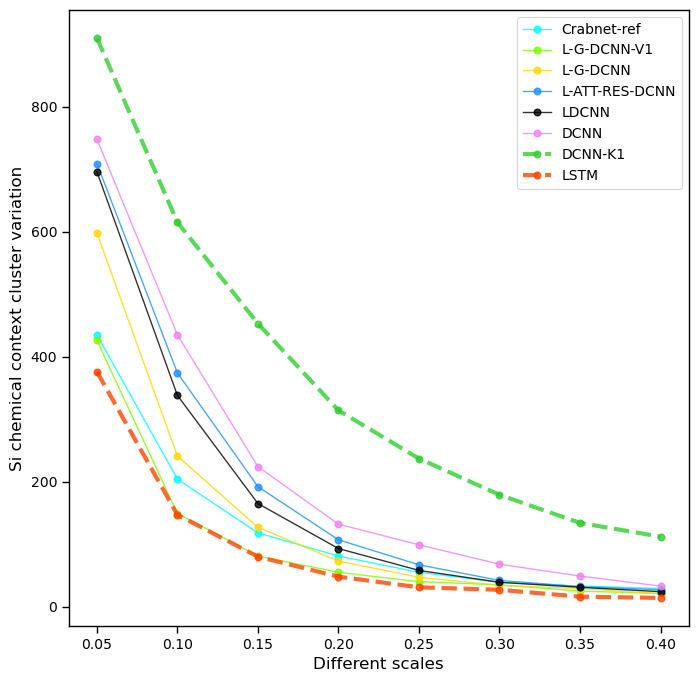

In [23]:
dict_L_ATT_RES = collections.OrderedDict()

exp0_key_region = ['Crabnet-ref','L-G-DCNN-V1','L-G-DCNN','L-ATT-RES-DCNN', 'LDCNN','DCNN','DCNN-K1','LSTM']
Crabnet = [435, 204, 118, 81, 55, 39, 33, 29]
# L_G_DCNN_f = [644, 288, 142, 91, 58, 36, 29, 21]
L_G_DCNN_V1 = [426, 149, 81, 55, 40, 35, 25, 21]
L_G_DCNN = [598, 241, 127, 73, 47, 34, 29, 21]
L_ATT_RES_DCNN = [709, 374, 192, 107, 67, 42, 32, 27]
LDCNN = [696, 338, 165, 93, 58, 39, 31, 24]
DCNN =  [748, 435, 224, 132, 99, 68, 49, 33]
DCNN_K1 = [910, 615, 453, 314, 237, 179, 134, 112]
LSTM = [376, 147, 80, 48, 31, 27, 16, 14]
exp0_key_v = [Crabnet, L_G_DCNN_V1, L_G_DCNN, L_ATT_RES_DCNN, LDCNN, DCNN, DCNN_K1, LSTM]
dict_L_ATT_RES['last0'] = dict(zip(exp0_key_region[:-2], exp0_key_v[:-2]))
dict_L_ATT_RES['label0'] = dict(zip(exp0_key_region[-2:], exp0_key_v[-2:]))

###############################################################################

# plot
x_value = np.linspace(0.05,0.2,4)
# c = ['dodgerblue', 'violet', 'gold', 'black','lime','lawngreen']
c = ['cyan','lawngreen','gold', 'dodgerblue', 'black','violet','limegreen', 'orangered']
plots = []
names = []
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
sns.color_palette("colorblind")
plt.figure(figsize=(8,8))

#################################################################################################
plots = []
names = []
# plt.subplot(2, 2, 1)
colors = collections.OrderedDict(zip(exp0_key_region[:-2], c[:-2]))
for key, value in dict_L_ATT_RES['last0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)


colors = collections.OrderedDict(zip(exp0_key_region[-2:], c[-2:]))
for key, value in dict_L_ATT_RES['label0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)


plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################

str_f_s = 'Fraction2000/paper/Fusion_frac5000'
fig_dir_overall = f'figures/{str_f_s}/'
fig_path = os.path.join(fig_dir_overall, f'fusion-V3-frac5000.jpg')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

## plot Fusion Strategy

In [2]:
import seaborn as sns

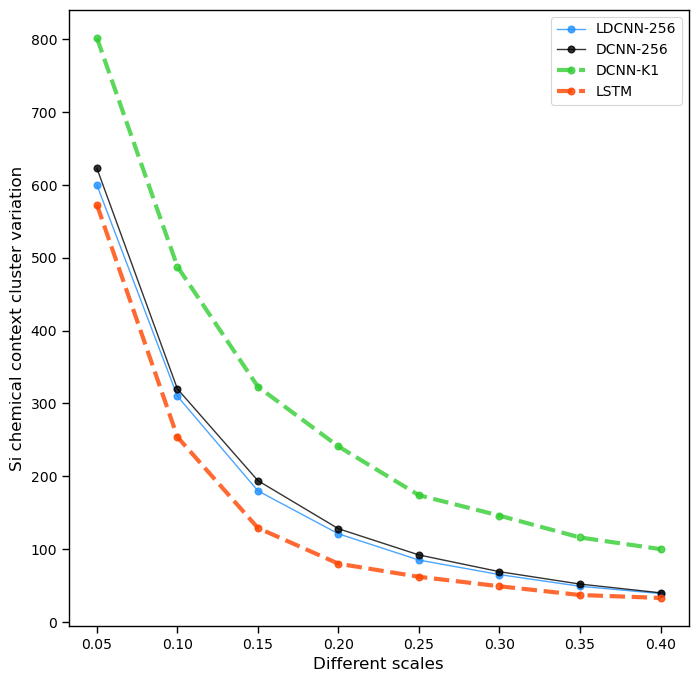

In [70]:
dict_L_ATT_RES = collections.OrderedDict()

exp0_key_region = ['LDCNN-256','DCNN-256','DCNN-K1','LSTM']
# LDCNN = [672, 356, 216, 155, 112, 88, 72, 57]
LDCNN = [600, 310, 180, 121, 85, 65, 49, 39]
DCNN =  [623, 320, 194, 128, 92, 69, 52, 40]
DCNN_K1 = [802,488,323,241,174,146,116,100]
LSTM = [573,254,129,80,62,49,37,33]

exp0_key_v = [LDCNN, DCNN, DCNN_K1, LSTM]
dict_L_ATT_RES['last0'] = dict(zip(exp0_key_region[:-2], exp0_key_v[:-2]))
dict_L_ATT_RES['label0'] = dict(zip(exp0_key_region[-2:], exp0_key_v[-2:]))

###############################################################################

# plot
x_value = np.linspace(0.05,0.2,4)
# c = ['dodgerblue', 'violet', 'gold', 'black']
c = ['dodgerblue', 'black','limegreen', 'orangered']
plots = []
names = []
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
sns.color_palette("colorblind")
plt.figure(figsize=(8,8))

#################################################################################################
plots = []
names = []
# plt.subplot(2, 2, 1)
colors = collections.OrderedDict(zip(exp0_key_region[:-2], c[:-2]))
for key, value in dict_L_ATT_RES['last0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)


colors = collections.OrderedDict(zip(exp0_key_region[-2:], c[-2:]))
for key, value in dict_L_ATT_RES['label0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)


plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################

str_f_s = 'Fraction2000/paper'
fig_dir_overall = f'figures/{str_f_s}/'
fig_path = os.path.join(fig_dir_overall, f'fusion01.jpg')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

## L-G-DCNN的数据量对MAE的影响解释


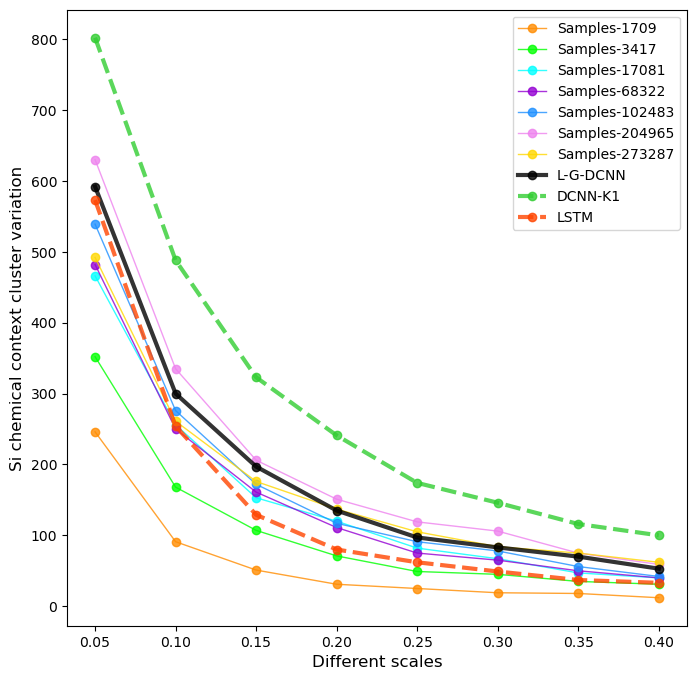

In [23]:
dict_L_ATT_RES = collections.OrderedDict()

exp0_key_region = ['Samples-1709','Samples-3417','Samples-17081','Samples-68322','Samples-102483','Samples-204965', 
                   'Samples-273287','L-G-DCNN','DCNN-K1','LSTM']
Samples1=[246, 91, 51, 31, 25, 19, 18, 12]
Samples2 = [352,168,107,71,49,45,35,31]
Samples3 =  [466,256,153,120,82,67,47,40]
Samples4 = [482,250,161,111,75,65,50,40]
Samples5 = [539,276,172,117,91,78,56,42]
Samples6 =[630,335,206,151,119,106,75,59]
Samples7 =[492,261,176,137,105,84,75,62]
Samples8 =[592,300,197,135,97,83,70,53]
DCNN_K1 = [802,488,323,241,174,146,116,100]
LSTM = [573,254,129,80,62,49,37,33]
exp0_key_v = [Samples1, Samples2, Samples3, Samples4, Samples5, Samples6, Samples7, Samples8, DCNN_K1, LSTM]
dict_L_ATT_RES['last0'] = dict(zip(exp0_key_region[:-3], exp0_key_v[:-3]))
dict_L_ATT_RES['label0'] = dict(zip([exp0_key_region[-3]], [exp0_key_v[-3]]))
dict_L_ATT_RES['label'] = dict(zip(exp0_key_region[-2:], exp0_key_v[-2:]))


###############################################################################

# plot
x_value = np.linspace(0.05,0.2,4)
# c = ['dodgerblue', 'violet', 'gold', 'black']
c = ['darkorange', 'lime', 'aqua','darkviolet',
      'dodgerblue','violet', 'gold', 'black','limegreen', 'orangered']
plots = []
names = []
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
sns.color_palette("colorblind")
plt.figure(figsize=(8,8))

#################################################################################################
plots = []
names = []
# plt.subplot(2, 2, 1)
colors = collections.OrderedDict(zip(exp0_key_region[:-3], c[:-3]))
for key, value in dict_L_ATT_RES['last0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)


colors = collections.OrderedDict(zip([exp0_key_region[-3]], [c[-3]]))
for key, value in dict_L_ATT_RES['label0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)


colors = collections.OrderedDict(zip(exp0_key_region[-2:], c[-2:]))
for key, value in dict_L_ATT_RES['label'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)


plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################
#################################
str_f_s = 'Fraction2000/paper'
fig_dir_overall = f'figures/{str_f_s}/'
fig_path = os.path.join(fig_dir_overall, f'sample_efficent_exp.jpg')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

### batch EAM对性能的影响

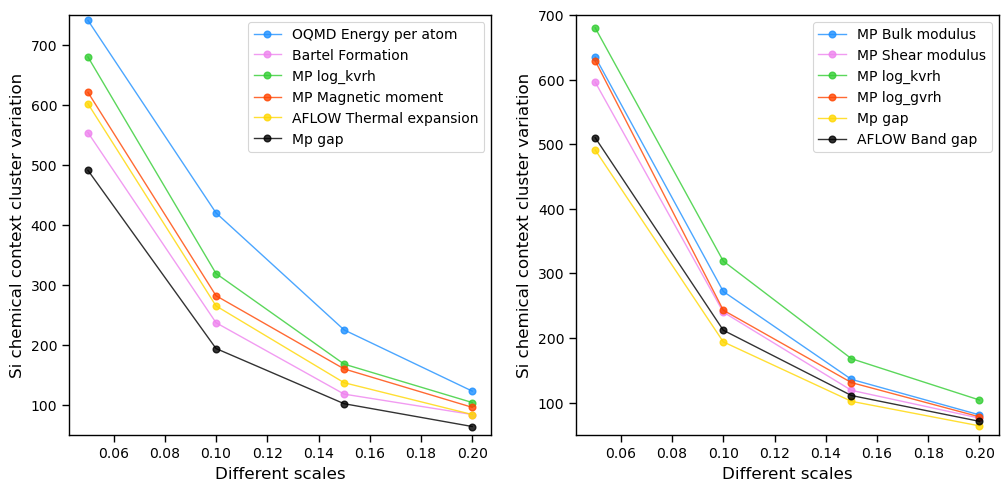

In [37]:
dict_L_ATT_RES = collections.OrderedDict()

exp0_key_region = ['OQMD Energy per atom','Bartel Formation','MP log_kvrh','MP Magnetic moment','AFLOW Thermal expansion'
                   ,'Mp gap']
OQMD_Energy_per_atom=[741, 420, 225, 123]
Bartel_Decomposition = [554, 237, 118, 84]
log_kvrh =  [680, 319, 168, 104]
MP_Magnetic_moment = [621, 282, 160, 96]
AFLOW_Thermal_expansion = [602, 265, 137, 84]
Mp_gap =[491, 194, 102, 64]
# AFLOW_Thermal_conductivity = [549,228,123,74]

exp0_key_v = [OQMD_Energy_per_atom, Bartel_Decomposition, log_kvrh, MP_Magnetic_moment, AFLOW_Thermal_expansion
              , Mp_gap]
dict_L_ATT_RES['last0'] = dict(zip(exp0_key_region, exp0_key_v))

###############################################################################
exp01_key_region = ['MP Bulk modulus','MP Shear modulus','MP log_kvrh','MP log_gvrh','Mp gap', 'AFLOW Band gap']
MP_Bulk_modulus = [635, 272, 136, 81]
MP_Shear_modulus = [596, 240, 119, 76]
log_kvrh =  [680, 319, 168, 104]
log_gvrh = [629, 243, 131, 78]
Mp_gap =[491, 194, 102, 64]
AFLOW_Band_gap = [510, 212, 111, 71]
exp01_key_v = [MP_Bulk_modulus, MP_Shear_modulus, log_kvrh, log_gvrh, Mp_gap, AFLOW_Band_gap]
dict_L_ATT_RES['region01'] = dict(zip(exp01_key_region, exp01_key_v))
###############################################################################

# plot
x_value = np.linspace(0.05,0.2,4)
c = ['dodgerblue', 'violet', 'limegreen', 'orangered', 'gold', 'black','cyan']
# c1 = ['dodgerblue', 'violet', 'gold', 'black']
plots = []
names = []
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
sns.color_palette("colorblind")
plt.figure(figsize=(12,12))

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 1)
colors = collections.OrderedDict(zip(exp0_key_region, c))
for key, value in dict_L_ATT_RES['last0'].items():
    
    plots.append(
        plt.plot(
            x_value,
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

plt.ylim([50,750])
plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 2)
colors = collections.OrderedDict(zip(exp01_key_region, c))
for key, value in dict_L_ATT_RES['region01'].items():
    
    plots.append(
        plt.plot(
            x_value,
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

plt.ylim([50,700])
plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)
#################################
str_f_s = 'Fraction2000/paper'
fig_dir_overall = f'figures/{str_f_s}/'
fig_path = os.path.join(fig_dir_overall, f'EAM_prop.jpg')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

## Ablation study or attention and residuals

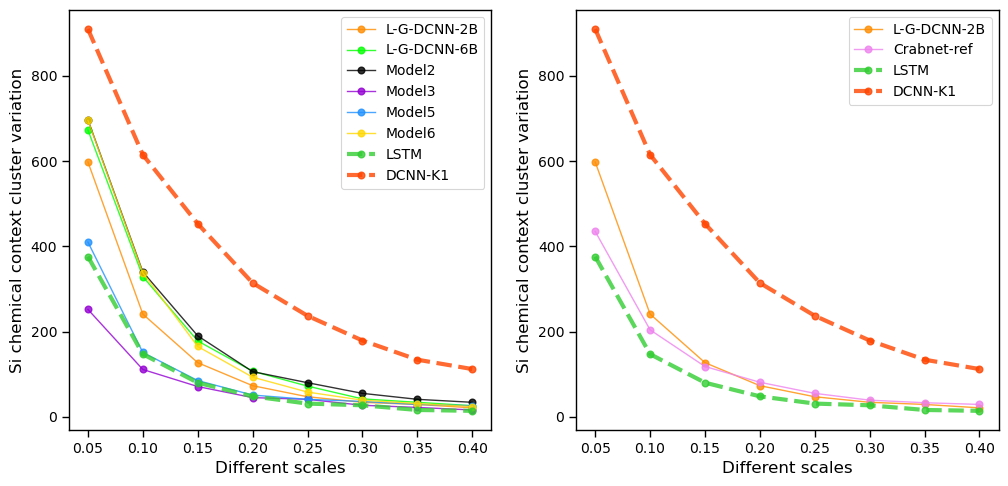

In [9]:
dict_L_ATT_RES = collections.OrderedDict()

exp0_key_region = ['L-G-DCNN-2B','L-G-DCNN-6B','Model2','Model3', 'Model5', 'Model6', 'LSTM','DCNN-K1']

L_G_DCNN_rate = [598, 241, 127, 73, 47, 34, 29, 21]
L_G_DCNN_6B = [673, 329, 178, 107, 72, 42, 34, 26]
Model2 = [697, 340, 190, 106, 80, 55, 41, 34]
Model3 = [252, 111, 71, 45, 41, 27, 22, 16]
Model5 = [410, 151, 85, 51, 41, 36, 29, 26]
Model6 = [696, 338, 165, 93, 58, 39, 31, 24]
LSTM_rate =  [376, 147, 80, 48, 31, 27, 16, 14]
DCNN_K1_rate = [910, 615, 453, 314, 237, 179, 134, 112]

# DCNN_last = [748, 435, 224, 132, 99, 68, 49, 33]
# LDCNN_6B_last = [761, 438, 228, 129, 81, 60, 42, 32]
exp0_key_v = [L_G_DCNN_rate, L_G_DCNN_6B, Model2, Model3, Model5, Model6, LSTM_rate, DCNN_K1_rate]
dict_L_ATT_RES['last0'] = dict(zip(exp0_key_region[:-2], exp0_key_v[:-2]))
dict_L_ATT_RES['label'] = dict(zip(exp0_key_region[-2:], exp0_key_v[-2:]))

exp01_key_region = ['L-G-DCNN-2B','Crabnet-ref','LSTM','DCNN-K1']
Crabnet = [435, 204, 118, 81, 55, 39, 33, 29]
exp01_key_v = [L_G_DCNN_rate, Crabnet, LSTM_rate, DCNN_K1_rate]
dict_L_ATT_RES['region01'] = dict(zip(exp01_key_region[:2], exp01_key_v[:2]))
dict_L_ATT_RES['label01'] = dict(zip(exp01_key_region[2:], exp01_key_v[2:]))

###############################################################################

# plot
x_value = np.linspace(0.05,0.2,4)
# c = ['dodgerblue', 'violet', 'limegreen', 'orangered', 'gold', 'black']
c = ['darkorange', 'lime',  'black', 'darkviolet',
      'dodgerblue', 'gold', 'aqua', 'limegreen', 'orangered']

c1 = ['darkorange', 'violet', 'limegreen', 'orangered']
plots = []
names = []
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
sns.color_palette("colorblind")
plt.figure(figsize=(12,12))

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 1)
colors = collections.OrderedDict(zip(exp0_key_region[:-2], c[:-2]))
for key, value in dict_L_ATT_RES['last0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

colors = collections.OrderedDict(zip(exp0_key_region[-2:], c[-2:]))
for key, value in dict_L_ATT_RES['label'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)

plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 2)
colors = collections.OrderedDict(zip(exp01_key_region[:2], c1[:2]))
for key, value in dict_L_ATT_RES['region01'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

colors = collections.OrderedDict(zip(exp01_key_region[2:], c1[2:]))
for key, value in dict_L_ATT_RES['label01'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4, 8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)
plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################
str_f_s = 'Fraction2000/paper/ablation'
fig_dir_overall = f'figures/{str_f_s}/'
fig_path = os.path.join(fig_dir_overall, f'ablation-paper1.jpg')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

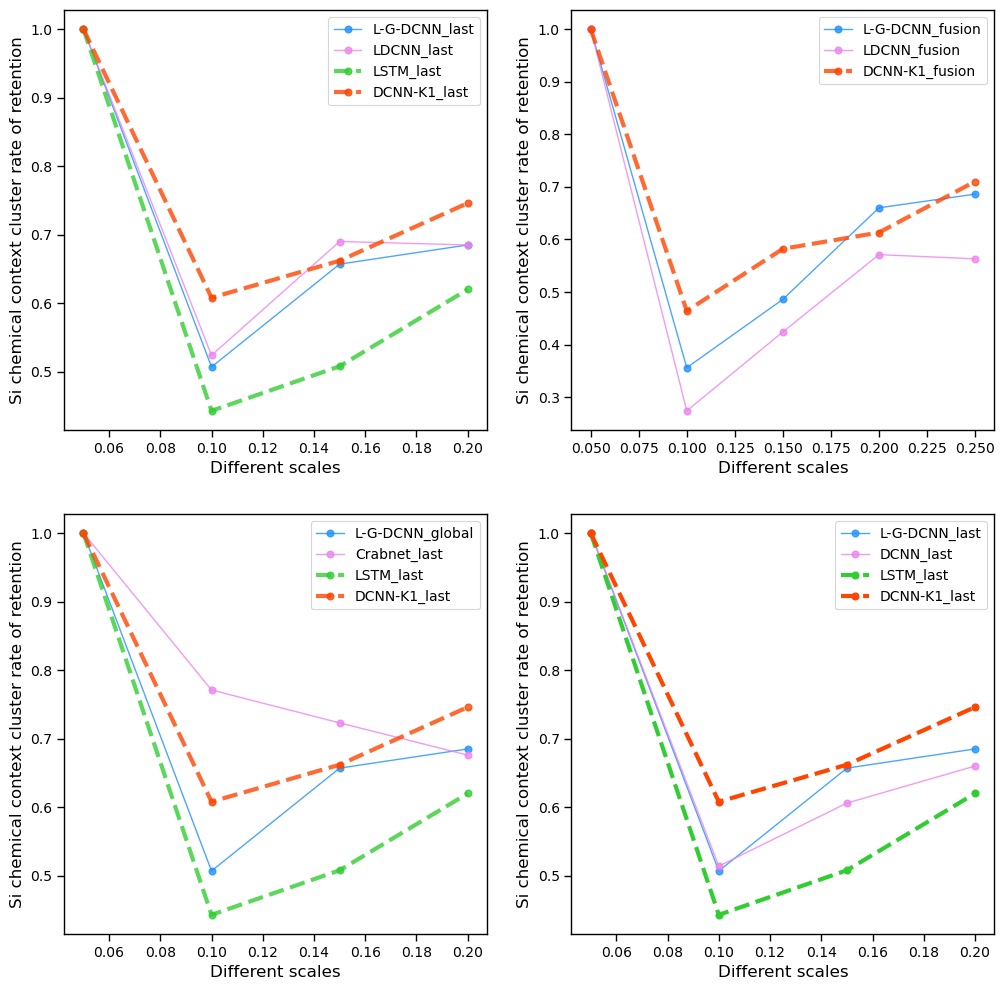

In [125]:
dict_L_ATT_RES = collections.OrderedDict()

exp0_key_region = ['L-G-DCNN_last','LDCNN_last','LSTM_last','DCNN-K1_last']
L_G_DCNN_rate = [1, 0.507, 0.657, 0.685]
LDCNN_rate = [1, 0.524, 0.69, 0.685]
LSTM_rate = [1, 0.443, 0.508, 0.62]
DCNN_K1_rate = [1, 0.608, 0.662, 0.746]
dict_L_ATT_RES['last0'] = dict(zip(exp0_key_region[:2], [L_G_DCNN_rate, LDCNN_rate]))
dict_L_ATT_RES['label'] = dict(zip(exp0_key_region[2:], [LSTM_rate, DCNN_K1_rate]))

exp01_key_region = ['L-G-DCNN_fusion','LDCNN_fusion','DCNN-K1_fusion']
L_ATT_DCNN_seq_region = [1, 0.356, 0.486, 0.66, 0.686, ]
L_ATT_DCNN_4B_seq_region = [1, 0.274, 0.424, 0.571, 0.563]
L_ATT_DCNN_5B_seq_region = [1, 0.464, 0.582, 0.613, 0.71]
dict_L_ATT_RES['region01'] = dict(zip(exp01_key_region[:2], [L_ATT_DCNN_seq_region, L_ATT_DCNN_4B_seq_region]))
dict_L_ATT_RES['label01'] = dict(zip([exp01_key_region[-1]], [L_ATT_DCNN_5B_seq_region]))

exp02_key_region = ['L-G-DCNN_global','Crabnet_last','LSTM_last','DCNN-K1_last']
Crabnet_last = [1, 0.771, 0.723, 0.676]
exp02_value_region = [ L_G_DCNN_rate, Crabnet_last, LSTM_rate, DCNN_K1_rate]
dict_L_ATT_RES['lstm02'] = dict(zip(exp02_key_region[:2], exp02_value_region[:2]))
dict_L_ATT_RES['label02'] = dict(zip(exp02_key_region[2:], exp02_value_region[2:]))

exp03_key_region = ['L-G-DCNN_last', 'DCNN_last', 'LSTM_last', 'DCNN-K1_last']
L_G_DCNN_rate = [1, 0.507, 0.657, 0.685]
DCNN_rate =     [1, 0.514, 0.606, 0.660]
DCNN_K1_rate = [1, 0.608, 0.662, 0.746]
LSTM_rate = [1, 0.443, 0.508, 0.62]
exp03_value_region = [L_G_DCNN_rate, DCNN_rate, LSTM_rate, DCNN_K1_rate]
dict_L_ATT_RES['lstm03'] = dict(zip(exp03_key_region[:2], exp03_value_region[:2]))
dict_L_ATT_RES['label03'] = dict(zip(exp03_key_region[2:], exp03_value_region[2:]))

###############################################################################

# plot
x_value = np.linspace(0.05,0.2,4)
c = ['dodgerblue', 'violet', 'limegreen', 'orangered']
plots = []
names = []
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
sns.color_palette("colorblind")
plt.figure(figsize=(12,12))

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 1)
colors = collections.OrderedDict(zip(exp0_key_region[:2], c[:2]))
for key, value in dict_L_ATT_RES['last0'].items():
    
    plots.append(
        plt.plot(
            x_value,
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

colors = collections.OrderedDict(zip(exp0_key_region[2:], c[2:]))
for key, value in dict_L_ATT_RES['label'].items():
    
    plots.append(
        plt.plot(
            x_value,
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)

plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster rate of retention",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 2)
colors = collections.OrderedDict(zip(exp01_key_region[:2], c[:2]))
for key, value in dict_L_ATT_RES['region01'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.25,5),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

colors = collections.OrderedDict(zip([exp01_key_region[-1]], [c[-1]]))
for key, value in dict_L_ATT_RES['label01'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.25, 5),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)
plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster rate of retention",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 3)
colors = collections.OrderedDict(zip(exp02_key_region[:2], c[:2]))
for key, value in dict_L_ATT_RES['lstm02'].items():
    
    plots.append(
        plt.plot(
            x_value,
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

colors = collections.OrderedDict(zip(exp02_key_region[2:], c[2:]))
for key, value in dict_L_ATT_RES['label02'].items():
    
    plots.append(
        plt.plot(
            x_value,
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)
plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster rate of retention",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 4)
colors = collections.OrderedDict(zip(exp03_key_region[:2], c[:2]))
for key, value in dict_L_ATT_RES['lstm03'].items():
    plots.append(
        plt.plot(
            np.linspace(0.05,0.2,4),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

colors = collections.OrderedDict(zip(exp03_key_region[2:], c[2:]))
for key, value in dict_L_ATT_RES['label03'].items():
    plots.append(
        plt.plot(
            np.linspace(0.05,0.2,4),
            value,
            color = colors[key],
            alpha=1,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)
plt.xlabel("Different scales",size = 12)
plt.ylabel("Si chemical context cluster rate of retention",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################
str_f_s = 'Fraction2000/paper'
fig_dir_overall = f'figures/{str_f_s}/'
fig_path = os.path.join(fig_dir_overall, f'local3.jpg')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

In [13]:
exp0_key_region[:-2]

['L-G-DCNN_last', 'LDCNN_last', 'DCNN_rate']

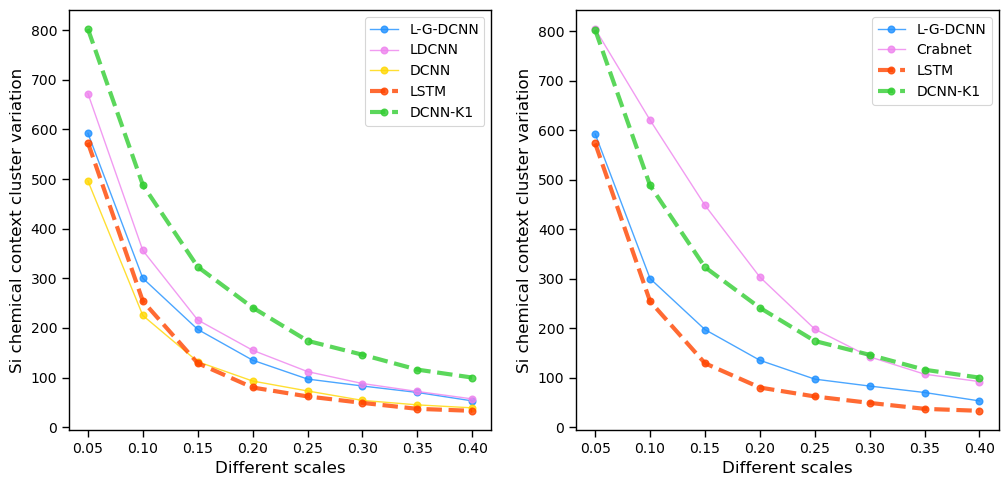

In [24]:
dict_L_ATT_RES = collections.OrderedDict()

exp0_key_region = ['L-G-DCNN','LDCNN','DCNN','LSTM','DCNN-K1']
L_G_DCNN_rate = [592, 300, 197, 135, 97, 83, 70, 53]
# LDCNN_rate = [395, 207, 143, 98, 70, 44, 36, 25]
LDCNN_rate = [672, 356, 216, 155, 112, 88, 72, 57] # 0.428
DCNN_rate =     [496, 225, 132, 93, 73, 54, 45, 39]
LSTM_rate =  [573, 254, 129, 80, 62, 49, 37, 33]
DCNN_K1_rate = [802, 488, 323, 241, 174, 146, 116, 100]
dict_L_ATT_RES['last0'] = dict(zip(exp0_key_region[:-2], [L_G_DCNN_rate, LDCNN_rate, DCNN_rate]))
dict_L_ATT_RES['label'] = dict(zip(exp0_key_region[-2:], [LSTM_rate, DCNN_K1_rate]))

# exp01_key_region = ['L-G-DCNN_fusion','LDCNN_fusion','DCNN-K1_fusion']
# L_ATT_DCNN_seq_region =    [306, 109, 53, 35, 24, 16, 11, 8]
# L_ATT_DCNN_4B_seq_region = [241, 66, 28, 16, 9, 6, 5, 5]
# L_ATT_DCNN_5B_seq_region = [604, 280, 163, 100, 71, 60, 46, 40]
# dict_L_ATT_RES['region01'] = dict(zip(exp01_key_region[:2], [L_ATT_DCNN_seq_region, L_ATT_DCNN_4B_seq_region]))
# dict_L_ATT_RES['label01'] = dict(zip([exp01_key_region[-1]], [L_ATT_DCNN_5B_seq_region]))


exp02_key_region = ['L-G-DCNN','Crabnet', 'LSTM', 'DCNN-K1']
L_G_DCNN_rate = [592, 300, 197, 135, 97, 83, 70, 53]
# Crabnet_last = [853, 693, 557, 430, 325, 238, 172, 134]
Crabnet_last = [804, 620, 448, 303, 198, 142, 107, 92]
DCNN_K1_rate = [802, 488, 323, 241, 174, 146, 116, 100]
LSTM_rate =  [573, 254, 129, 80, 62, 49, 37, 33]
exp02_value_region = [ L_G_DCNN_rate, Crabnet_last, LSTM_rate, DCNN_K1_rate]
dict_L_ATT_RES['lstm02'] = dict(zip(exp02_key_region[:2], exp02_value_region[:2]))
dict_L_ATT_RES['label02'] = dict(zip(exp02_key_region[2:], exp02_value_region[2:]))

# exp03_key_region = ['L-G-DCNN_last', 'DCNN_last', 'LSTM_last', 'DCNN-K1_last']
# L_G_DCNN_rate = [592, 300, 197, 135, 97, 83, 70, 53]
# DCNN_rate =     [623, 320, 194, 128, 92, 69, 52, 40]
# DCNN_K1_rate = [802, 488, 323, 241, 174, 146, 116, 100]

# exp03_value_region = [L_G_DCNN_rate, DCNN_rate,LSTM_rate, DCNN_K1_rate]
# dict_L_ATT_RES['lstm03'] = dict(zip(exp03_key_region[:2], exp03_value_region[:2]))
# dict_L_ATT_RES['label03'] = dict(zip(exp03_key_region[2:], exp03_value_region[2:]))

###############################################################################

# plot
# x_value = np.linspace(0.05,0.2,4)
c = ['dodgerblue', 'violet','gold', 'orangered', 'limegreen']
# c = ['dodgerblue', 'violet', 'limegreen', 'orangered', 'gold', 'black','cyan']
plots = []
names = []
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
sns.color_palette("colorblind")
plt.figure(figsize=(12,12))

#################################################################################################
plots = []
names = []
plt.subplot(2, 2, 1)
colors = collections.OrderedDict(zip(exp0_key_region[:-2], c[:-2]))
for key, value in dict_L_ATT_RES['last0'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

colors = collections.OrderedDict(zip(exp0_key_region[-2:], c[-2:]))
for key, value in dict_L_ATT_RES['label'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)

plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)

#################################################################################################

plots = []
names = []
plt.subplot(2, 2, 2)
colors = collections.OrderedDict(zip(exp02_key_region[:2], c[:2]))
for key, value in dict_L_ATT_RES['lstm02'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=1,
            marker='o',linestyle='-'
        )[0]
    )
    names.append(key)

colors = collections.OrderedDict(zip(exp02_key_region[-2:], c[-2:]))
for key, value in dict_L_ATT_RES['label02'].items():
    
    plots.append(
        plt.plot(
            np.linspace(0.05,0.4,8),
            value,
            color = colors[key],
            alpha=0.8,
            linewidth=3,
            marker='o',linestyle='--'
        )[0]
    )
    names.append(key)
plt.xlabel("Different scales",size=12)
plt.ylabel("Si chemical context cluster variation",size = 12)
plt.legend(plots, names, loc='best',fontsize=10)


#################################
str_f_s = 'Fraction2000/paper'
fig_dir_overall = f'figures/{str_f_s}/'
fig_path = os.path.join(fig_dir_overall, f'local-capture-influence.jpg')
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
plt.show()

In [522]:
formu_5

array(['Yb2Be2Ni(SnO5)2', 'K3Na4Sn3BF22', 'Na3BeAl(SnO4)2',
       'Ba3NbFe3(SnO7)2', 'CaAl4Sn2(HO6)2', 'K2ScSn4O10F',
       'Dy5Mg5Al12(Fe2Sn3)2', 'NaCaSnHO4', 'Rb5LiNi(SnO4)2', 'Ba3SnPHO8',
       'Ba3CaCuSn6O17', 'CrSnH8(O2F3)2', 'BaCa2Mg(SnO4)2',
       'KNaMn(Sn2O5)2', 'Ca3TaGa3(SnO7)2', 'SrLi4Ca(SnO4)2', 'NaSn2BH2O7',
       'CaAl2Sn2(H2O5)2', 'Mn13Al4Sn2(SbO14)2', 'Ba3NbGa3(SnO7)2',
       'K5La4Sn4O16F', 'Mn9Al2Sn8(HO4)8', 'BeAlSnHO5', 'KBaYSn2O7',
       'K3SnN(OF2)3', 'CaAlSnO4F', 'Li4Al3Sn3ClO12', 'CaAlSnHO5',
       'RbNa3Li12(SnO4)4', 'CaAl2Sn(HO2)4', 'KSn2H14C4N',
       'BaSr2Mn2(Sn2O7)2', 'Na2SrAl4(SnO4)4', 'Sr3TaGa3(SnO7)2',
       'Pr2SnC(NO2)2', 'NaZnSnHO4', 'NaCa2Sn3HO9', 'Cs2KU2(Sn2O7)2',
       'Ba3Zn6Sn4TeO20', 'Y5Mg5Al12(Fe2Sn3)2', 'Li4Ga3Sn3IO12',
       'SnH12C2(NF)6', 'Na2TiSn4H4O13', 'Cs3SnPHO8', 'K4Nb8Sn(P2O17)2',
       'Li4Ga3Sn3BrO12', 'BaNa2Al4(SnO4)4', 'AlSnH11C3O', 'F1Na3O9Si3Sn1',
       'Ca7Sn6H4CO23', 'K2Be2Zn2Sn3O11', 'CaSnBHO5', 'KNaCu(Sn2O5)2',

In [555]:
formu_7

array(['Al2B1Ca2Fe1H1O16Si4', 'Ba4Ca1Na2O26S2Si4Ti3'], dtype=object)

## 其他的矩阵相似度比较方法

In [362]:
all_dict = dict(zip(formu,save_num))
index_coll = dict()
p_threshold = 0.95
k = 0
for k1,values in all_dict.items():
    ll_k = []
    ll_v = []
    vv_k = []
    vv_v = []
    for k2,value_q in all_dict.items():
        p_v = pearsonr(values.reshape(9,),value_q.reshape(9,))[0]
        if p_v > p_threshold:
            ll_v.append(value_q)
            ll_k.append(k2)
        else:
            vv_v.append(value_q)
            vv_k.append(k2)
    if len(ll_v) != 0:
        index_coll[str(k)] = dict(zip(ll_k, ll_v))
        k = k+1
    if len(vv_v) != 0: 
        all_dict = dict()
        all_dict = dict(zip(vv_k, vv_v))
        
        
# index_coll[str(k)] = dict(zip([k1], [values]))

In [376]:
len(index_coll)

42

In [315]:
vec2 = save_num[0].reshape(9,)
count_v = []
for i in range(save_num.shape[0]-1):
    vec1 = save_num[i].reshape(9,)
    # v = np.sum(vec1 * vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    v = pearsonr(vec2,vec1)[0]
    # v = eculidDisSim(vec2,vec1)
    # v = manhattanDisSim(vec2,vec1)
    # v = cosSim(vec2,vec1)
    count_v.append(v)


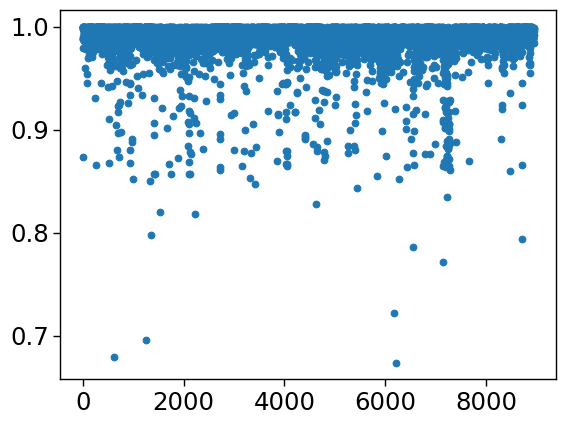

In [320]:
plt.scatter(range(count_v.shape[0]),count_v)

## 绘制每个环境下所有的图


In [ ]:
fig_dir = f'figures/correlation_atoms_L-ATT-RES-DCNN-512/Env/{str_f}/3/'

# plot static figure
# cmap = sns.diverging_palette(10, 250, n=200, center='light')
cmap = sns.diverging_palette(260, 15, s=70, l=55, n=1000,center='light')
# cbar_kws = dict(shrink=0.9)

for i,v in index_coll.items():
    fig_dir1 = os.path.join(fig_dir, f'{i}')
    os.makedirs(fig_dir1, exist_ok=True)
    for k_s, dic_v in v.items():
        corr = dic_v
        f_ele = Composition(k_s).elements
        z_ticks = [str(j) for j in f_ele]
        fig = plt.figure(figsize=(12,12))
        ax = sns.heatmap(
                corr,
                xticklabels=z_ticks,
                yticklabels=z_ticks,
                vmin=-1, vmax=1, center=0,
                # vmin=0, vmax=1, center=0.5,
                annot=True,
                annot_kws={"fontsize":15},
                fmt=".2f",
                cmap=cmap,
                linewidth=.5,
                square=True,
                # cbar_kws=cbar_kws
            )
        ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=45,
                horizontalalignment='center'
            )
        ax.set_yticklabels(
                ax.get_yticklabels(),
                rotation=45,
                horizontalalignment='center'
            )
                
        plt.xlabel("element")
        plt.ylabel("element")

        for tick in ax.xaxis.get_major_ticks():
                tick.set_pad(1)
        for tick in ax.yaxis.get_major_ticks():
                tick.set_pad(15)
        fig_path = os.path.join(fig_dir1, f'OQMD_Bandgap_Final_out_layer_4_{k_s}_corr_atoms.png')
        plt.savefig(fig_path, bbox_inches='tight', dpi=200)
        plt.close('all')

## 每个相似环境下抽出一张 组成所有环境 拼接matrix 绘制一张图

In [9]:
# corr = np.abs(puzzle_arr_trans_diff).max(axis=1).reshape(puzzle_arr_trans_diff.shape[0],-1)
# corr=np.linalg.norm(puzzle_arr_trans_diff, ord=2, axis=1, keepdims=True) # 范数2
# corr = np.sort(puzzle_arr_trans_diff)
# col_num = 2
# ss = np.sort(puzzle_arr_trans_diff, axis=1)
# corr = ss[np.argsort(ss[:,col_num])]

# corr_conc = np.concatenate((corr, corr_4,corr_5,corr_6,corr_7),axis=0) 
# corr_conc = np.concatenate((corr, corr_4, corr_5, corr_6),axis=0) 

corr_conc = np.concatenate((corr, corr_4),axis=0) 
str_f_r = 'correlation_atoms_L-ATT-RES-1-DCNN-512-model_design'

# 绘图并保存 

fig_dir_overall = f'figures/{str_f_r}/{s_d}/{str_f}/{thred_v}/'
os.makedirs(fig_dir_overall, exist_ok=True)


# plot static figure
cmap = sns.diverging_palette(260, 15, s=80, l=50, n=10, center='light')
cbar_kws = dict(shrink=0.8)
fig = plt.figure(figsize=(3,30))
ax = sns.heatmap(
                sorted(corr_conc),
                # xticklabels=z_ticks,
                # yticklabels=z_ticks,
                # vmin=0.5, vmax=1,
                # vmin=0.85, vmax=1.25, center=1.05,
                # vmin=0.8, vmax=1.3, center=1.05,
                annot=True,
                annot_kws={"fontsize":5},
                fmt=".3f",
                cmap=cmap,
                # cmap='rainbow',
                linewidth=.5,
                cbar_kws=cbar_kws
            )

ax.set_xticks([])
ax.set_yticklabels(
                ax.get_yticklabels(),
                rotation=45,
                horizontalalignment='center',fontsize='small'
            )

 
plt.xlabel("Environmental feature embedding vectors")
plt.ylabel("Chemical environment")
plt.title(f'{str_f}')

for tick in ax.xaxis.get_major_ticks():
                tick.set_pad(1)
for tick in ax.yaxis.get_major_ticks():
                tick.set_pad(15)

# fig_path = os.path.join(fig_dir_overall, f'OQMD_Bandgap_Sequential_out_layer_{num}_ENV__{str_f}_corr_atoms.jpg')

fig_path = os.path.join(fig_dir_overall, f'OQMD_Bandgap_LSTM_out_layer_0_ENV_{str_f}_corr_atoms.jpg')

plt.savefig(fig_path, bbox_inches='tight', dpi=400)
plt.close('all')

In [10]:
corr_conc.shape

(88, 1)

## test

In [ ]:
import umap
n_components = 3
n_neighbors = 2
min_dist = 0.0001
Xred = umap.UMAP(metric='cosine', n_neighbors=n_neighbors,
                              n_components=n_components,
                              min_dist=min_dist, random_state=42)
Xemb = Xred.fit_transform(X) # Xemb:(51242, 2)


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)
X_r

array([[-1.00869555e+01, -1.16913740e+01,  2.89351876e-15],
       [-5.67858317e+00,  1.40948266e+01,  2.91121294e-14],
       [ 1.57655387e+01, -2.40345257e+00, -2.98372438e-14]])

In [ ]:
X_r.shape

(3, 3)

In [ ]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names